### Ablation study: Loss $\mathcal L_\mathrm{geo}$, dataset $\mathcal S$

In [1]:
import multiprocessing as mp
import numpy as np

In [2]:
def objective_process(result_queue):
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import numpy as np
    
    import DissimilarityMetrics
    import ChannelChartingCore
    import Evaluation

    import dichasus_cf0x

    print("Loading Dataset...")
    groundtruth_positions = []
    csi_time_domain = []
    timestamps = []
    
    for csi, pos, time in dichasus_cf0x.trainingset.batch(1000):
        csi_time_domain.append(csi.numpy())
        groundtruth_positions.append(pos.numpy())
        timestamps.append(time.numpy())
    
    csi_time_domain = np.concatenate(csi_time_domain)
    groundtruth_positions = np.concatenate(groundtruth_positions)
    timestamps = np.concatenate(timestamps)
    
    MEASUREMENT_INTERVAL = 0.048
    timestamps = timestamps - timestamps[0]
    timestamps = np.round(timestamps / MEASUREMENT_INTERVAL) * MEASUREMENT_INTERVAL

    Evaluation.plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")

    @tf.function
    def compute_adp_dissimilarity_matrix(csi_array):
        output = tf.TensorArray(tf.float32, size = csi_array.shape[0])
    
        powers = tf.einsum("lbrmt,lbrmt->lbt", csi_array, tf.math.conj(csi_array))
        for i in tf.range(csi_array.shape[0]):
            w = csi_array[i:,:,:,:]
            h = csi_array[i,:,:,:]
    
            dotproducts = tf.abs(tf.square(tf.einsum("brmt,lbrmt->lbt", tf.math.conj(h), w)))
            d_new = tf.math.reduce_sum(1 - dotproducts / tf.math.real(powers[i] * powers[i:]), axis = (1, 2))
            d = tf.concat([tf.zeros(i), tf.maximum(d_new, 0)], 0)
    
            output = output.write(i, d)
    
        dissim_upper_tri = output.stack()
        return dissim_upper_tri + tf.transpose(dissim_upper_tri)
    
    adp_dissimilarity_matrix = compute_adp_dissimilarity_matrix(csi_time_domain).numpy()

    # Ablation study: Edge weights are now deterministic, based on existing code from [dissimilarity-metric based Channel Charting tutorial](https://dichasus.inue.uni-stuttgart.de/tutorials/tutorial/dissimilarity-metric-channelcharting/).

    # Compute timestamp-based dissimilarity matrix
    timestamp_dissimilarity_matrix = np.abs(np.subtract.outer(timestamps, timestamps))

    TIME_THRESHOLD = 2
    small_time_dissimilarity_indices = np.logical_and(timestamp_dissimilarity_matrix < TIME_THRESHOLD, timestamp_dissimilarity_matrix > 0)
    small_time_dissimilarities = timestamp_dissimilarity_matrix[small_time_dissimilarity_indices]
    small_adp_dissimilarities = adp_dissimilarity_matrix[small_time_dissimilarity_indices]
    
    n_bins = 1500
    
    fig, ax1 = plt.subplots()
    occurences, edges, patches = ax1.hist(small_adp_dissimilarities / small_time_dissimilarities, range = (0, 50), bins = n_bins)
    ax1.set_xlabel("$D_\mathrm{APDP} / D_\mathrm{time}$")
    ax1.set_ylabel("Number of Occurences")

    bin_centers = edges[:-1] + np.diff(edges) / 2.
    max_bin = np.argmax(occurences)
    min_threshold = np.quantile(occurences[:max_bin], 0.5)
    
    for threshold_bin in range(max_bin - 1, -1, -1):
        if occurences[threshold_bin] < min_threshold:
            break
    
    scaling_factor = bin_centers[threshold_bin]
    
    plt.bar(bin_centers[:max_bin], occurences[:max_bin], width = edges[1] - edges[0])
    plt.axhline(y = min_threshold, color = 'r', linestyle = '-')
    plt.text(4, min_threshold + 10, "Mode Separation Threshold", color = 'r',)
    plt.axvline(x = scaling_factor, color = 'r', linestyle = '-')
    plt.xlabel("$D_\mathrm{APDP} / D_\mathrm{time}$")
    plt.ylabel("Number of Occurences")
    plt.show()
    
    print("gamma = ", scaling_factor)

    # Fuse ADP-based and time-based dissimilarity matrices
    dissimilarity_matrix_fused = np.minimum(adp_dissimilarity_matrix, timestamp_dissimilarity_matrix * scaling_factor)

    class DeterministicDissimilarityMetric(DissimilarityMetrics.GaussianDissimilarityMetric):
        def __init__(self, dissimilarity_matrix, beta):
            self.dissimilarity_matrix = dissimilarity_matrix
            self.beta = beta
        
        def get_realization(self, output_matrix, variance_scale):
            output_matrix[:] = self.dissimilarity_matrix
    
        def mean_variance_along_path(self, paths, mask):
            dissimilarities = self.dissimilarity_matrix[paths[:,:-1], paths[:,1:]]
            dissimilarities_sum = np.sum(np.where(mask, dissimilarities, 0), axis = 1)
    
            return dissimilarities_sum, (dissimilarities_sum + self.beta) / 2
        
        def get_datapoint_count(self):
            return self.dissimilarity_matrix.shape[0]
    
        def is_contractable(self):
            return False
    
    beta = np.quantile(dissimilarity_matrix_fused, 0.01)
    dissimilarity_metric = DeterministicDissimilarityMetric(dissimilarity_matrix_fused, beta)

    GDM = ChannelChartingCore.GaussianDissimilarityModel([dissimilarity_metric])
    GDM.generate_short_paths(total_path_count = 40000, realization_count = 1)

    MIN_BATCH_SIZE = 500
    MAX_BATCH_SIZE = 4000
    LEARNING_RATE_INITIAL = 1.5e-2
    LEARNING_RATE_FINAL = 1e-2
    MAX_HOPLENGTH = 1500.0
    MIN_HOPLENGTH = 7.0
    MAX_PATHHOPS = 50
    TRAINING_BATCHES = 3000

    # Ablation Study: Disable acceleration constraint by setting `ACCELERATION_WEIGHT = 0`
    ACCELERATION_MEAN = 0.0
    ACCELERATION_VARIANCE = 0.5
    ACCELERATION_WEIGHT = 0 #1e-4
    
    plot_callback = None # Evaluation.PlotChartCallback(groundtruth_positions, csi_time_domain.shape[0], max_hops = MAX_PATHHOPS)
    cc = ChannelChartingCore.ChannelChart(GDM, csi_time_domain, timestamps, min_batch_size = MIN_BATCH_SIZE, max_batch_size = MAX_BATCH_SIZE, learning_rate_initial = LEARNING_RATE_INITIAL, learning_rate_final = LEARNING_RATE_FINAL, max_hoplength = MAX_HOPLENGTH, min_hoplength = MIN_HOPLENGTH, randomize_pathhops = False, training_batches = TRAINING_BATCHES, plot_callback = plot_callback, acceleration_mean = ACCELERATION_MEAN, acceleration_variance = ACCELERATION_VARIANCE, acceleration_weight = ACCELERATION_WEIGHT, max_pathhops = MAX_PATHHOPS)

    channel_chart_positions = cc.predict(csi_time_domain)
    ct, tw, ks = Evaluation.ct_tw_ks_on_subset(groundtruth_positions, channel_chart_positions)
    print(f"CT: {ct:.4f}\nTW: {tw:.4f}\nKS: {ks:.4f}")

    channel_chart_positions_transformed, errorvectors, errors, mae, cep = Evaluation.mean_absolute_error_transformed(groundtruth_positions, channel_chart_positions)
    Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "CC After Affine Transform")

    print(f"MAE: {mae:.4f}\nCEP: {cep:.4f}")
    
    result_queue.put((mae, cep))

In [3]:
maes = []
ceps = []

result_queue = mp.Queue()

2024-12-04 08:28:51.464378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 08:28:52.278503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 08:28:53.578572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 08:28:53.633126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 08:29:21.440004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


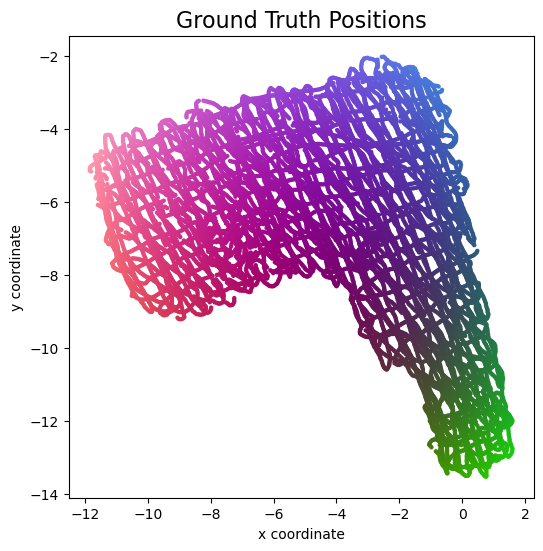

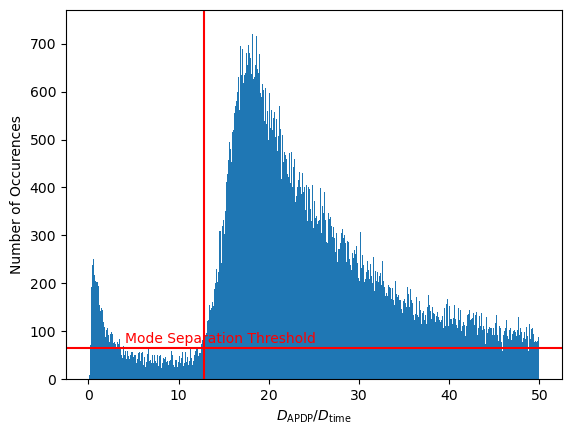

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733301124.785540 1626662 service.cc:145] XLA service 0x7fafeaac0df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733301124.785578 1626662 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 08:32:04.879934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 08:32:05.219793: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 08:32:06.170854: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:39 33ms/step - loss: 513.9464

I0000 00:00:1733301127.602493 1626662 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 841/3000 ━━━━━━━━━━━━━━━━━━━━ 1:30 42ms/step - loss: 98.4417CT: 0.9965
TW: 0.9962
KS: 0.0901


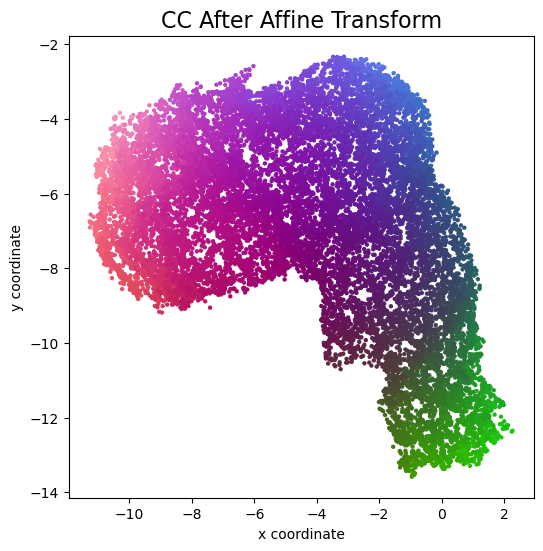

MAE: 0.3298
CEP: 0.2970


2024-12-04 08:34:24.837946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 08:34:25.747371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 08:34:27.245966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 08:34:27.302459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 08:35:11.367715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


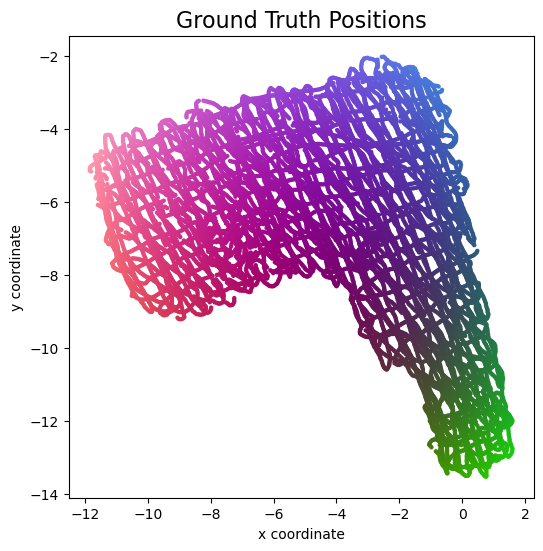

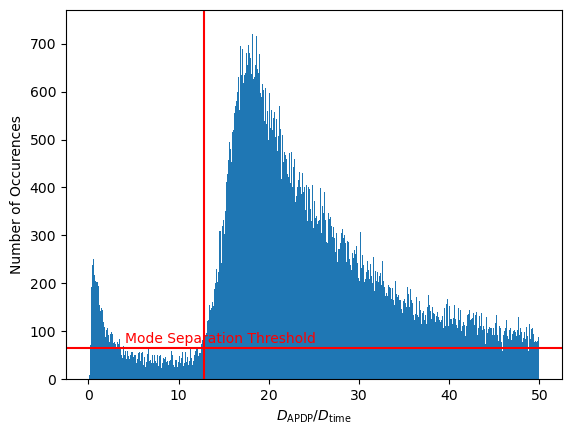

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733301473.169755 1634931 service.cc:145] XLA service 0x7fafe80b1590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733301473.169807 1634931 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 08:37:53.296656: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 08:37:53.631911: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 08:37:54.560276: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:40 34ms/step - loss: 512.4742

I0000 00:00:1733301475.985189 1634931 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1753/3000 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - loss: 58.6315

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733302825.669780 1669084 service.cc:145] XLA service 0x7fb01c1fe6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733302825.669821 1669084 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:00:25.760193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:00:26.104286: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:00:27.018486: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:38 33ms/step - loss: 513.3826

I0000 00:00:1733302828.436712 1669084 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 41.9221
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9972
TW: 0.9967
KS: 0.0686


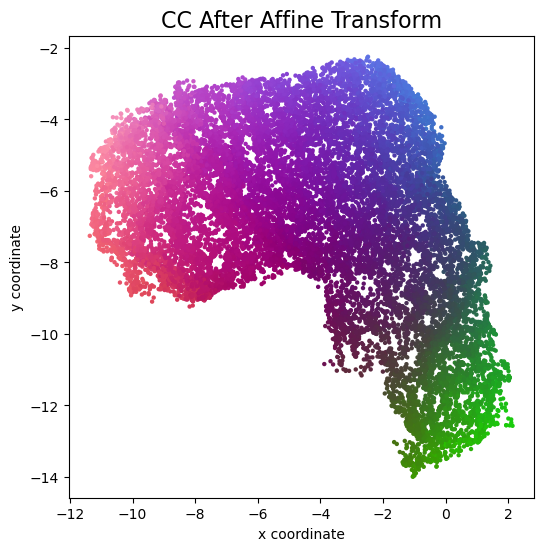

MAE: 0.3503
CEP: 0.3235


2024-12-04 09:02:45.763943: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:02:46.559933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:02:47.802978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:02:47.855247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:03:20.283921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


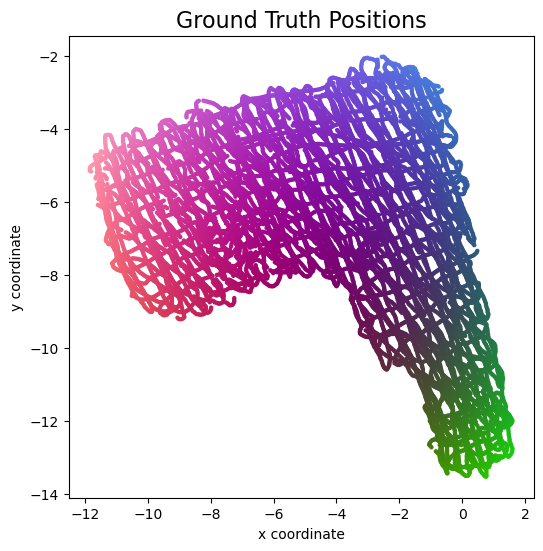

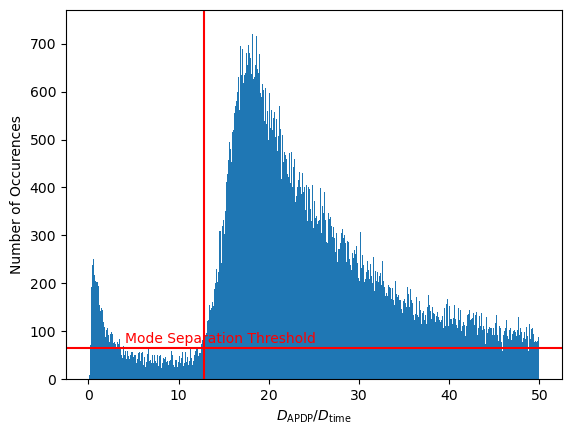

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733303159.768216 1677379 service.cc:145] XLA service 0x7fb02019dab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733303159.768261 1677379 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:05:59.875032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:06:00.206331: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:06:01.171950: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:40 33ms/step - loss: 512.3416

I0000 00:00:1733303162.601487 1677379 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.2451
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9969
TW: 0.9965
KS: 0.0748


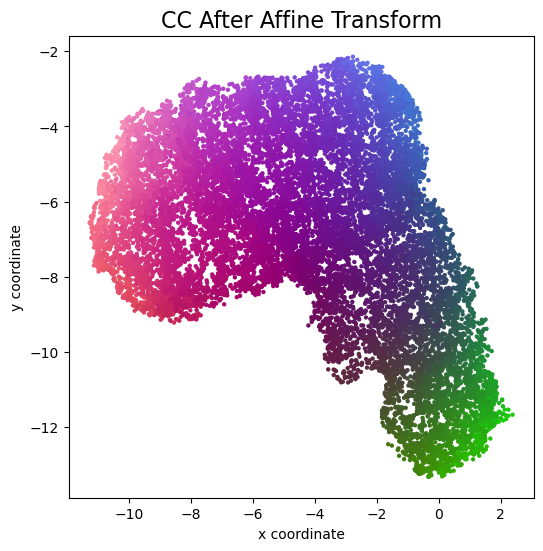

MAE: 0.3527
CEP: 0.3144


2024-12-04 09:08:19.638599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:08:20.461842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:08:21.795987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:08:21.849618: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:08:51.655450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


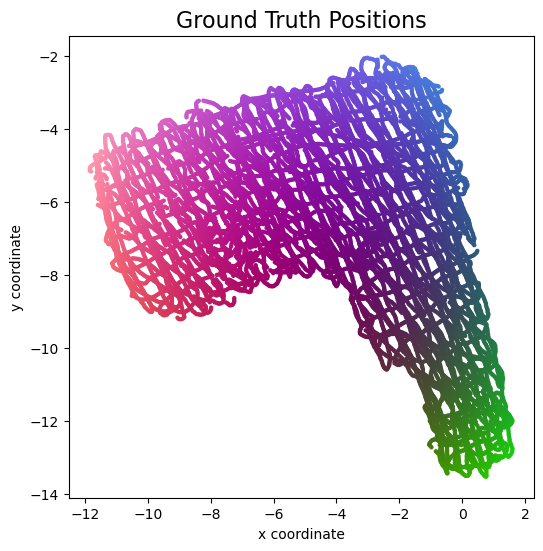

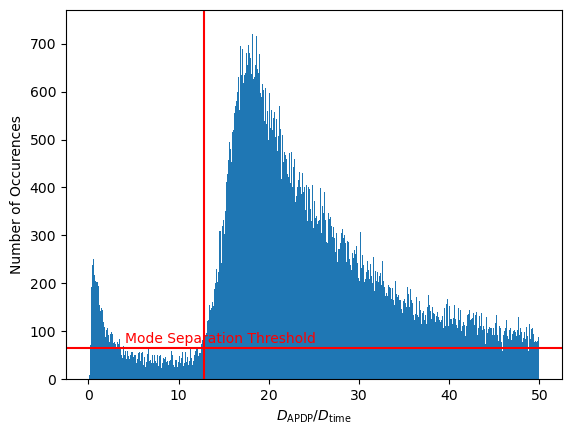

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


I0000 00:00:1733303491.228153 1685717 service.cc:145] XLA service 0x7fb00018d420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733303491.228194 1685717 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:11:31.332968: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:11:31.659518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:11:32.607656: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:38 33ms/step - loss: 511.7632

I0000 00:00:1733303494.033052 1685717 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.2675
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9972
TW: 0.9968
KS: 0.0734


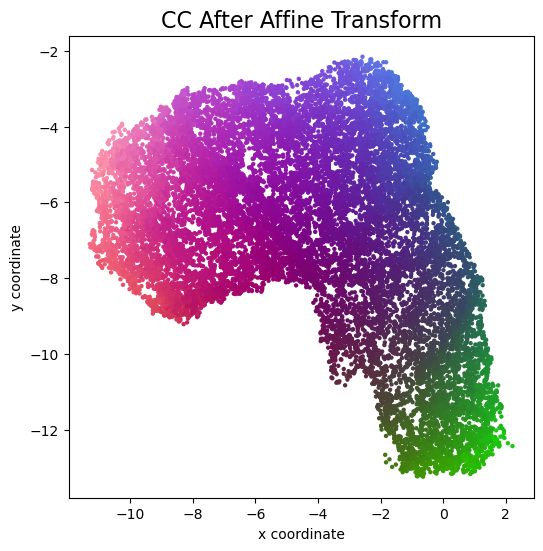

MAE: 0.3249
CEP: 0.2973


2024-12-04 09:13:51.036651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:13:51.833759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:13:53.084053: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:13:53.138290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:14:25.537015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


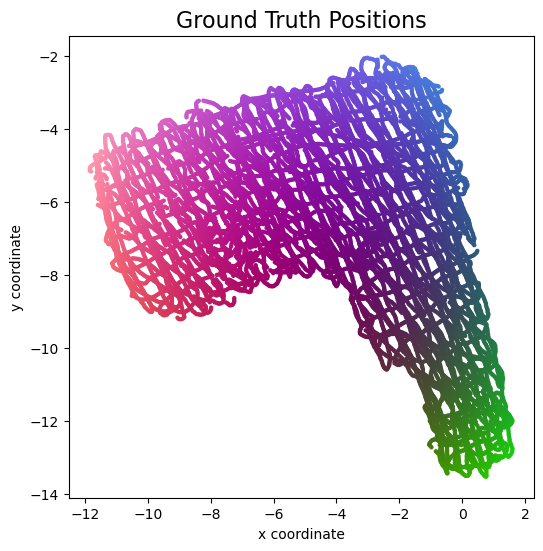

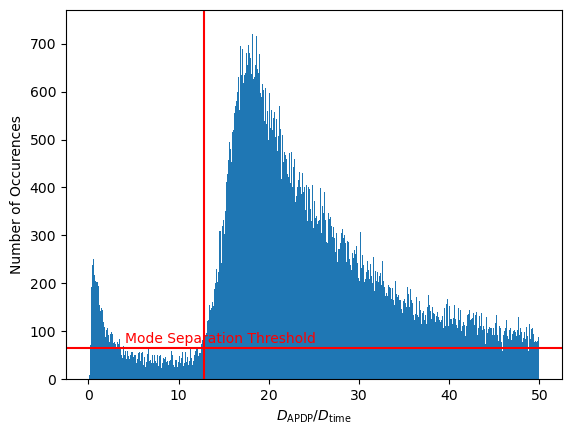

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733303824.682498 1694088 service.cc:145] XLA service 0x7fafe6c040e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733303824.682544 1694088 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:17:04.793339: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:17:05.144971: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:17:06.122317: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:39 33ms/step - loss: 512.2931

I0000 00:00:1733303827.552064 1694088 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 39.9503
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9971
TW: 0.9967
KS: 0.0729


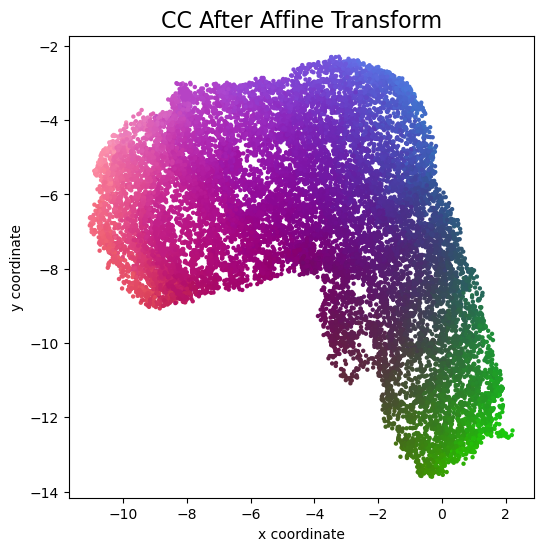

MAE: 0.3338
CEP: 0.2986


2024-12-04 09:19:24.502496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:19:25.317933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:19:26.634140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:19:26.688800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:19:56.329546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


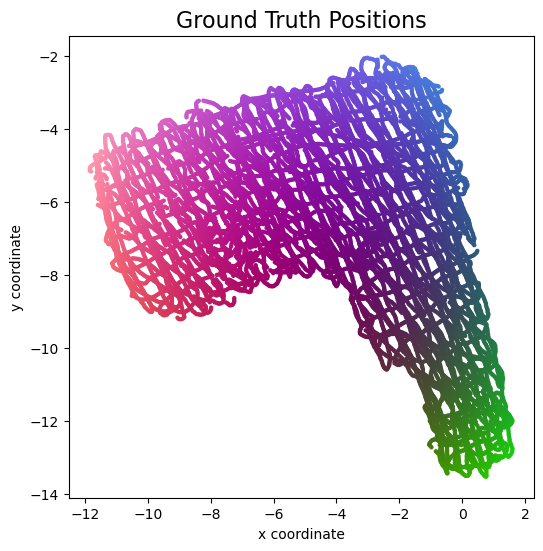

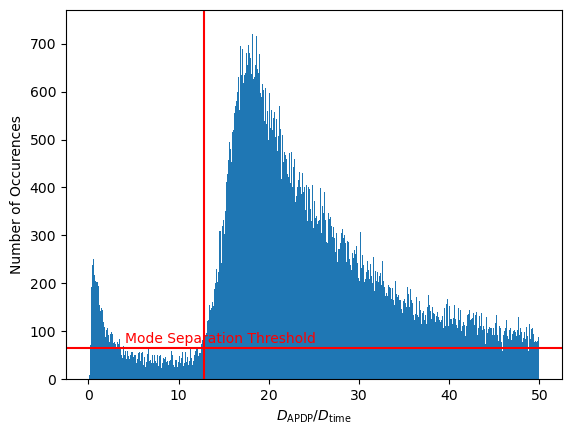

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733304155.655105 1702406 service.cc:145] XLA service 0x7fb01c19ed70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733304155.655163 1702406 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:22:35.779378: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:22:36.122174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:22:37.078786: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:39 33ms/step - loss: 509.2878

I0000 00:00:1733304158.512507 1702406 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.3507
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CT: 0.9973
TW: 0.9969
KS: 0.0687


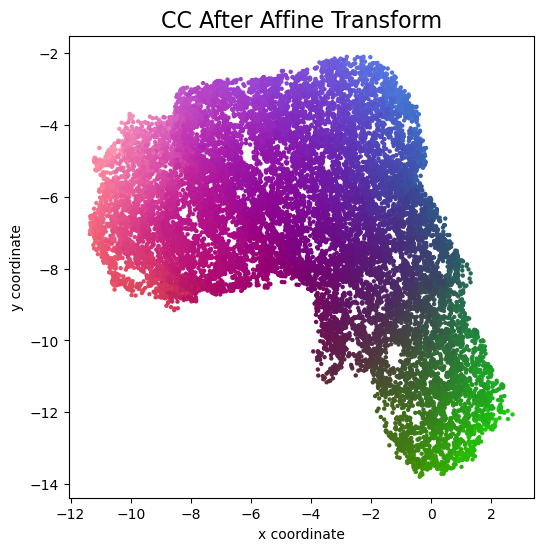

MAE: 0.3584
CEP: 0.3291


2024-12-04 09:24:55.825743: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:24:56.667216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:24:58.033284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:24:58.091508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:25:42.995948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


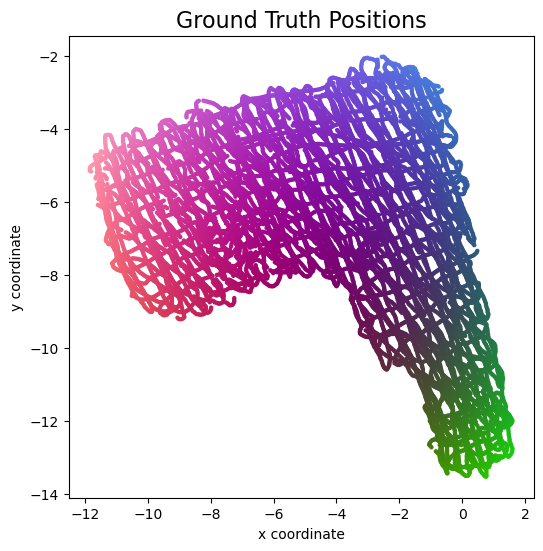

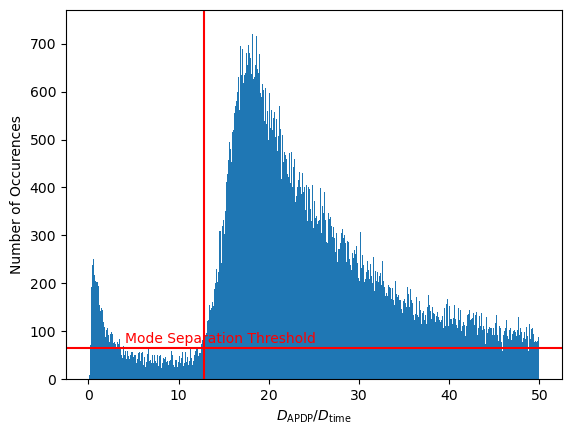

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733304504.237013 1710708 service.cc:145] XLA service 0x7fb0081d0cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733304504.237055 1710708 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:28:24.324773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:28:24.652478: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:28:25.588878: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:39 33ms/step - loss: 513.7571

I0000 00:00:1733304507.014951 1710708 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 42.3657
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CT: 0.9968
TW: 0.9966
KS: 0.0760


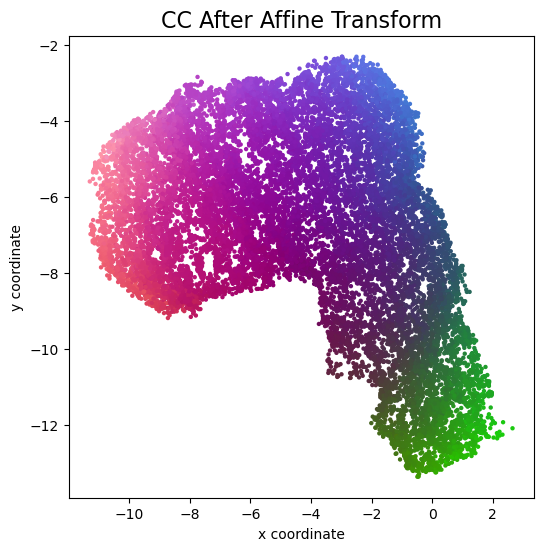

MAE: 0.3344
CEP: 0.2990


2024-12-04 09:30:44.160273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:30:44.934129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:30:46.163636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:30:46.214864: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:31:15.169717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


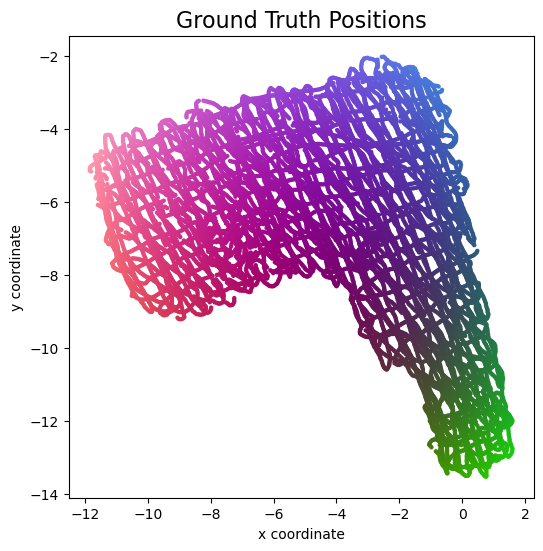

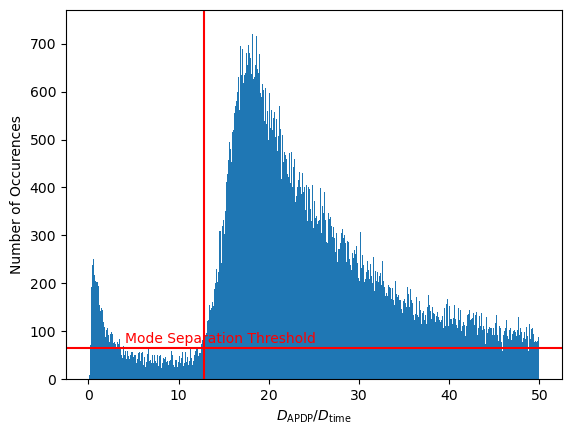

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733304834.026644 1719113 service.cc:145] XLA service 0x7fb01c0d8170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733304834.026678 1719113 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:33:54.114687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:33:54.443005: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:33:55.377940: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:36 32ms/step - loss: 513.3680

I0000 00:00:1733304836.796424 1719113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.4371
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CT: 0.9973
TW: 0.9969
KS: 0.0644


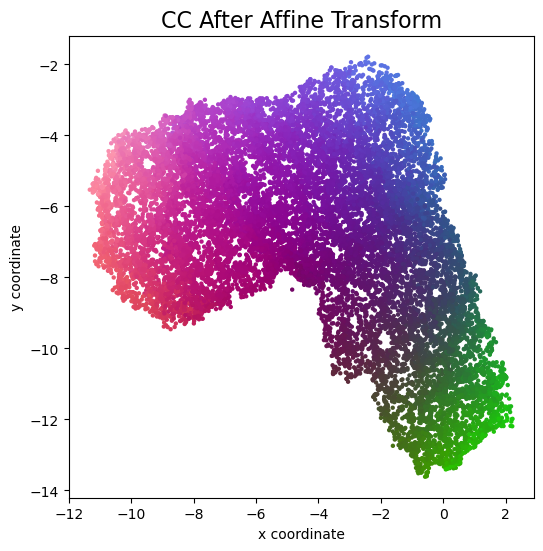

MAE: 0.3136
CEP: 0.2681


2024-12-04 09:36:13.860758: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:36:14.674264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:36:15.981854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:36:16.034848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...
Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733305166.091839 1727433 service.cc:145] XLA service 0x7faff46b5740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733305166.091901 1727433 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:39:26.215030: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:39:26.556374: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:39:27.493280: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:38 33ms/step - loss: 512.4601

I0000 00:00:1733305168.919288 1727433 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.8069
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9972
TW: 0.9964
KS: 0.0729


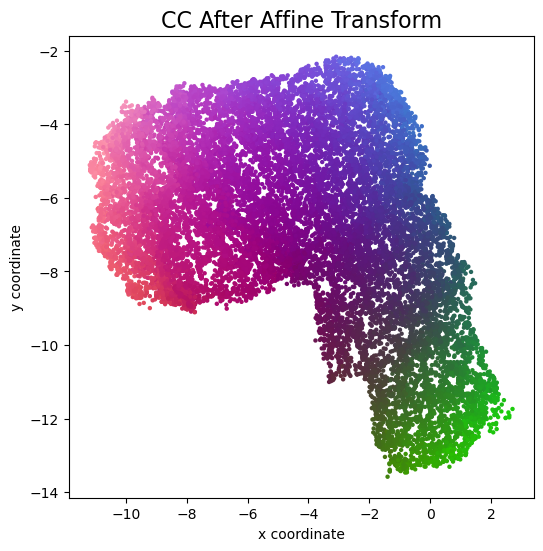

MAE: 0.3431
CEP: 0.3114


2024-12-04 09:41:46.251785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:41:47.229670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:41:48.788990: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:41:48.861281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:42:21.710803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


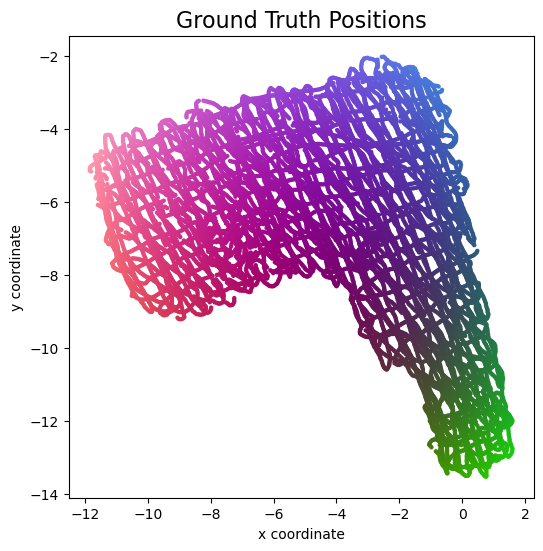

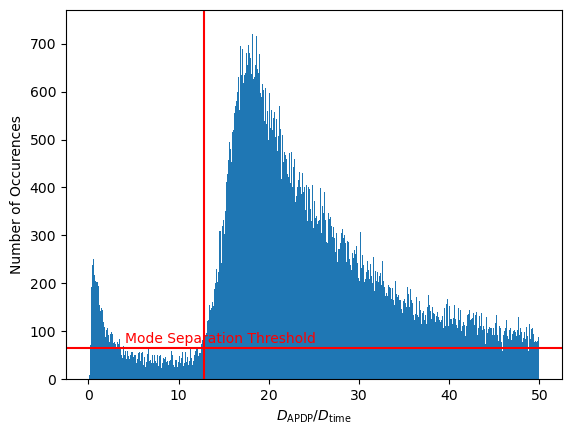

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733305514.381525 1735797 service.cc:145] XLA service 0x7faff811e840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733305514.381586 1735797 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:45:14.509004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:45:14.844381: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:45:15.777103: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:37 33ms/step - loss: 510.7228

I0000 00:00:1733305517.200613 1735797 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 39.9218
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9972
TW: 0.9966
KS: 0.0744


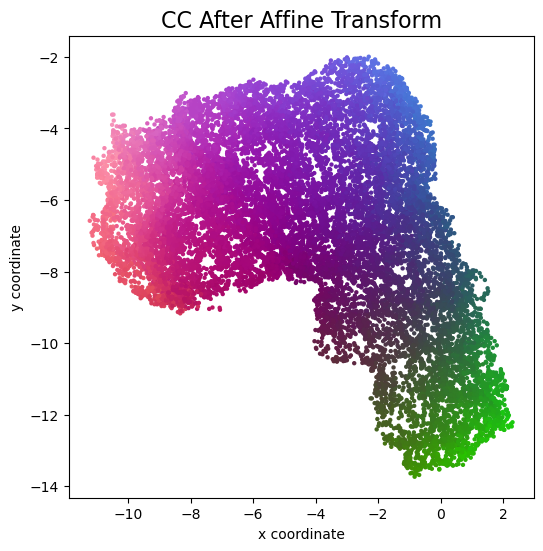

MAE: 0.3498
CEP: 0.3181


2024-12-04 09:47:34.206519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:47:35.020874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:47:36.298119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:47:36.351826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:48:06.138970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


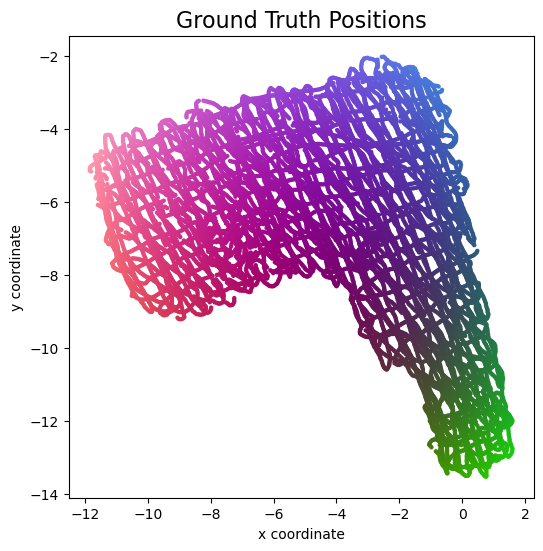

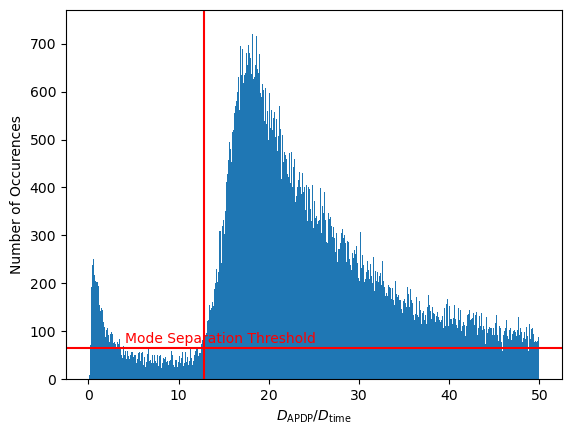

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733305845.346323 1744353 service.cc:145] XLA service 0x7fb00019f530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733305845.346361 1744353 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:50:45.453007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:50:45.783368: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:50:46.719352: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:39 33ms/step - loss: 513.8364

I0000 00:00:1733305848.137358 1744353 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 41.0691
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9971
TW: 0.9968
KS: 0.0707


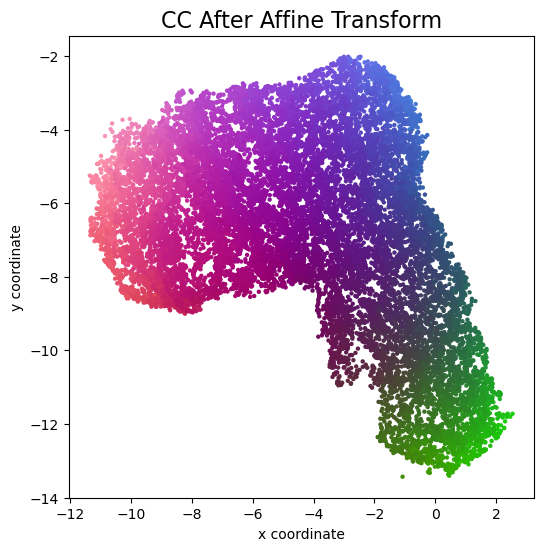

MAE: 0.3490
CEP: 0.3133


2024-12-04 09:53:05.204277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:53:06.003099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:53:07.243031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:53:07.295108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:53:36.983937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


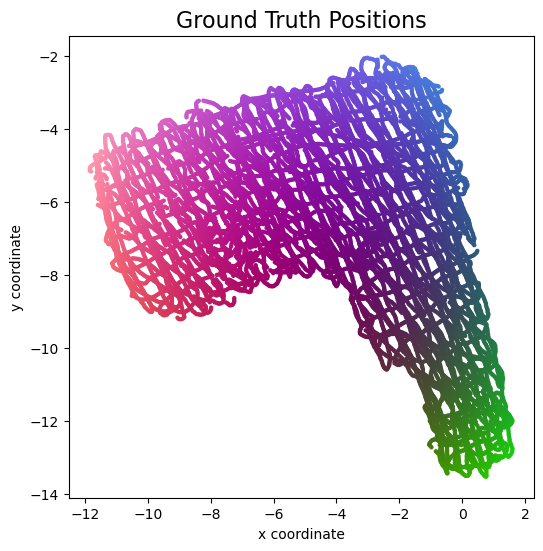

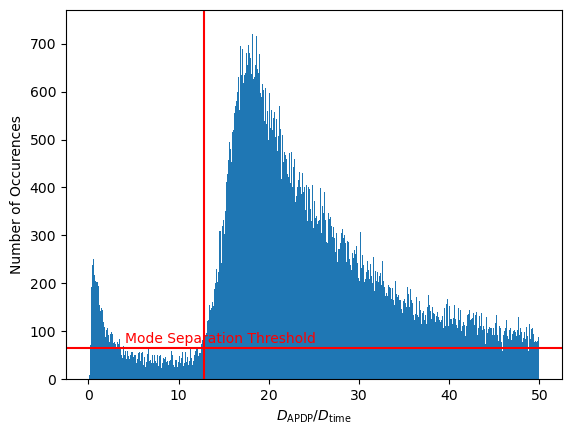

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733306178.260462 1752692 service.cc:145] XLA service 0x7faffc19f150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733306178.260521 1752692 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 09:56:18.390379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 09:56:18.759371: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 09:56:19.711967: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:39 33ms/step - loss: 512.2554

I0000 00:00:1733306181.130252 1752692 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.2919
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9970
TW: 0.9967
KS: 0.0709


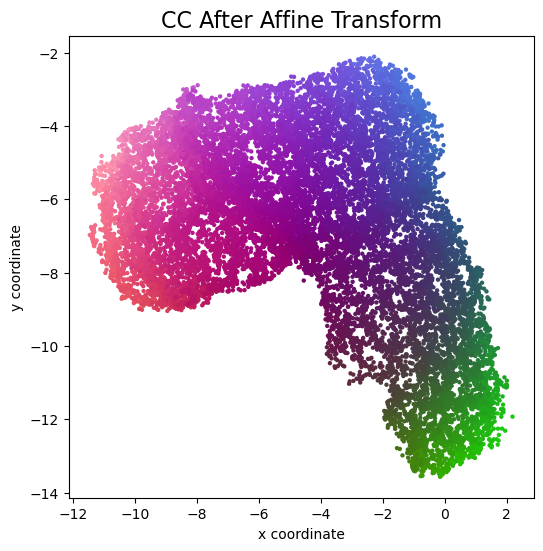

MAE: 0.3216
CEP: 0.3012


2024-12-04 09:58:37.906540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:58:38.723500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 09:58:40.112347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 09:58:40.171056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 09:59:09.955950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


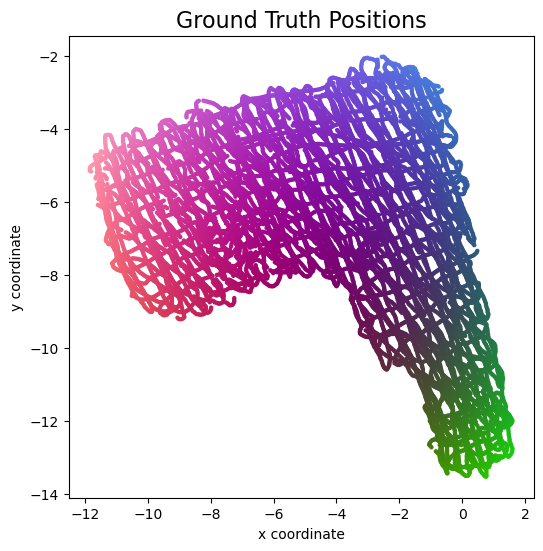

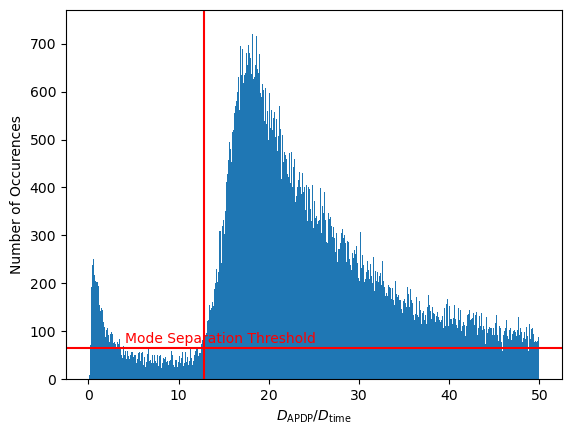

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733306510.297705 1761011 service.cc:145] XLA service 0x7fb000296580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733306510.297758 1761011 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 10:01:50.421988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 10:01:50.750367: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 10:01:51.668616: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:38 33ms/step - loss: 511.3670

I0000 00:00:1733306513.096114 1761011 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.9830
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9971
TW: 0.9967
KS: 0.0778


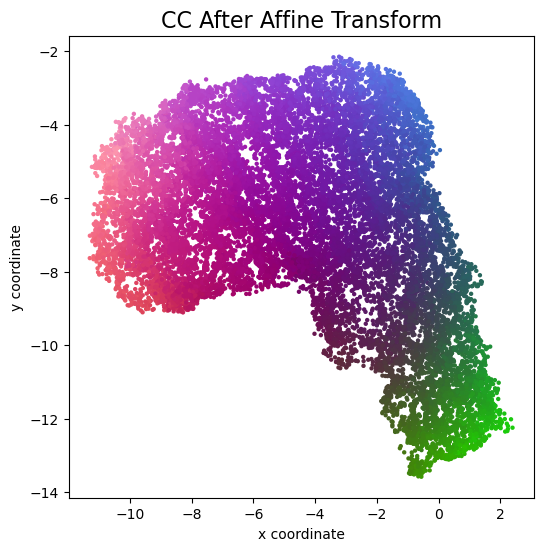

MAE: 0.3408
CEP: 0.3118


2024-12-04 10:04:10.093676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 10:04:10.932080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 10:04:12.311643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 10:04:12.363706: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 10:04:42.538218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


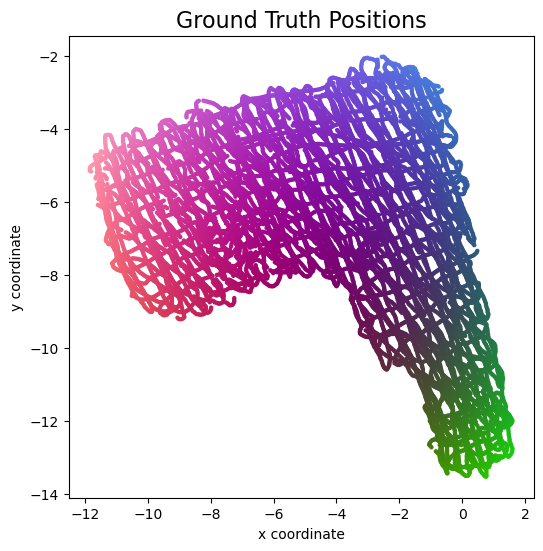

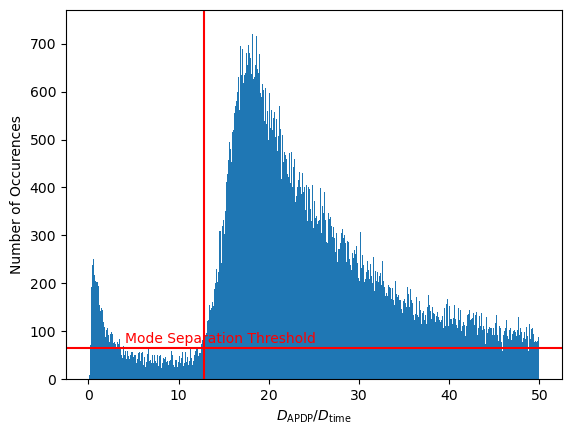

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733306845.465429 1769312 service.cc:145] XLA service 0x7fb0140b0f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733306845.465490 1769312 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 10:07:25.593438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 10:07:25.924376: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 10:07:26.848575: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:40 34ms/step - loss: 511.6835

I0000 00:00:1733306848.267356 1769312 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 46.8828
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9967
TW: 0.9966
KS: 0.0789


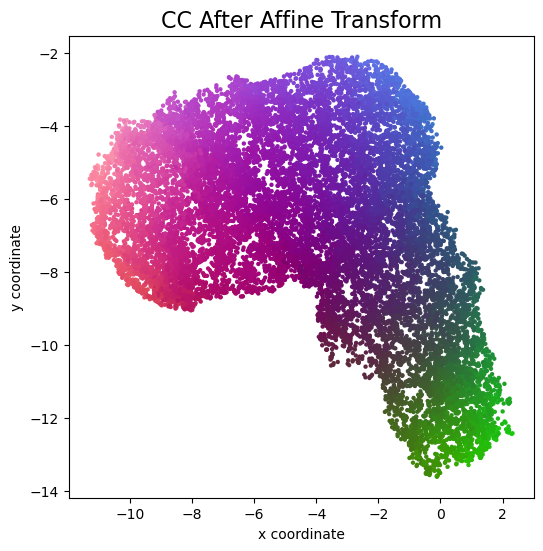

MAE: 0.3532
CEP: 0.3360


2024-12-04 10:09:45.374992: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 10:09:46.172561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 10:09:47.419009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 10:09:47.471327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 10:10:17.107672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


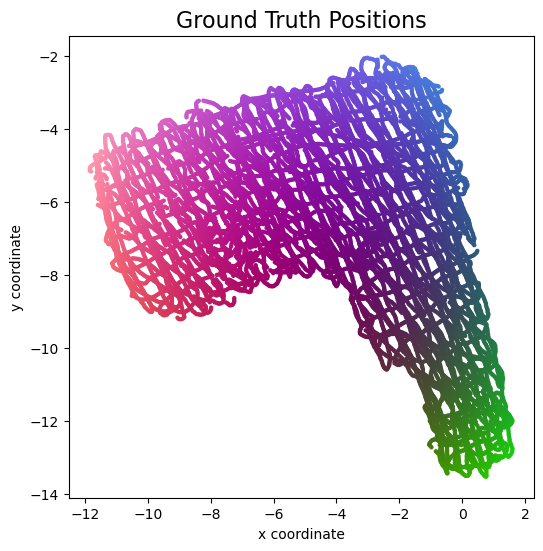

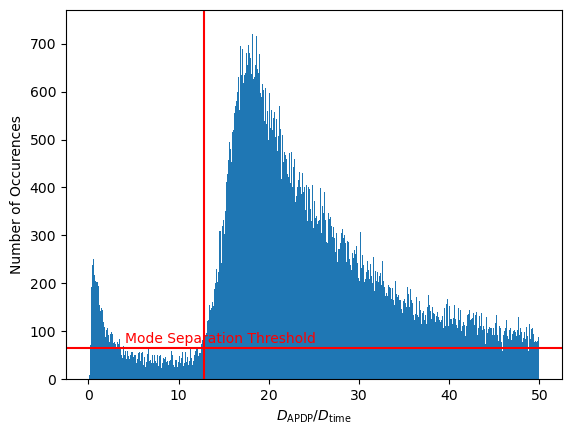

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733307182.086760 1777722 service.cc:145] XLA service 0x7faffc0e3d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733307182.086810 1777722 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 10:13:02.220223: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 10:13:02.560578: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 10:13:03.467990: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:38 33ms/step - loss: 512.4114

I0000 00:00:1733307184.899308 1777722 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.0612
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CT: 0.9972
TW: 0.9967
KS: 0.0815


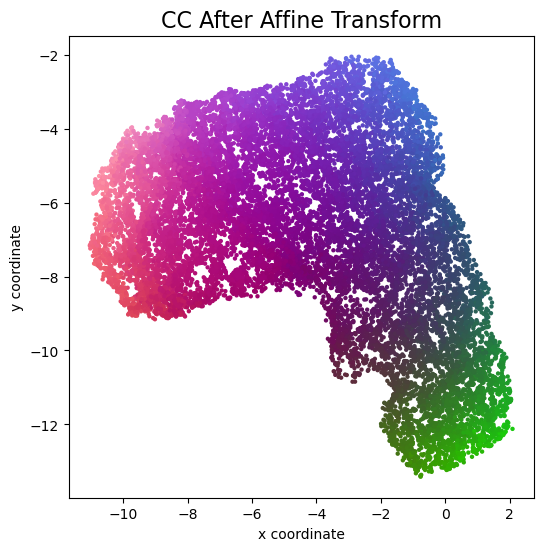

MAE: 0.3515
CEP: 0.3147


2024-12-04 10:15:22.063893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 10:15:22.854024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 10:15:24.141910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 10:15:24.199449: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 10:16:07.916946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


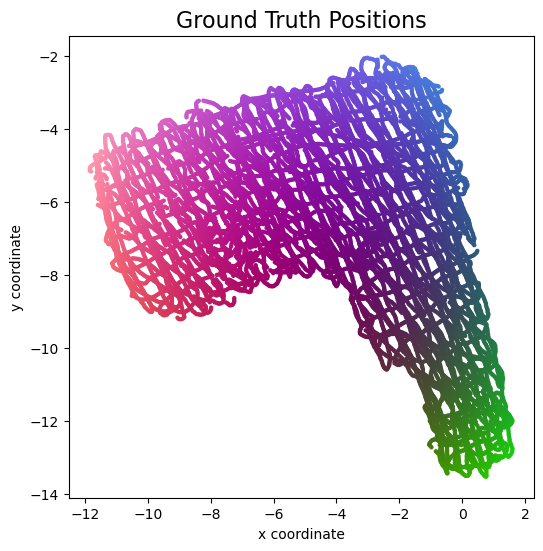

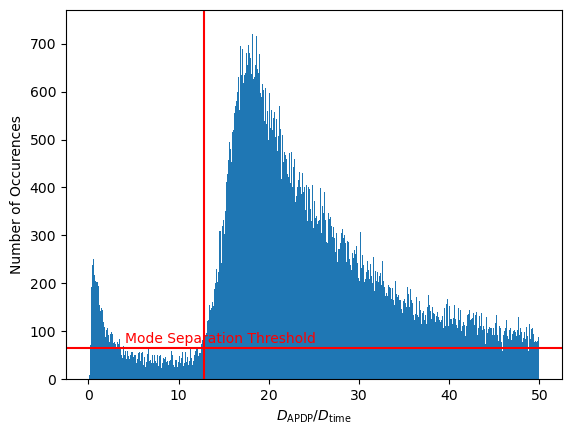

gamma =  12.816666603088379


  0%|          | 0/1 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/1 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/834040000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/16 [00:00<?, ?it/s]

Longest short path has 77 hops


Pre-computing training paths:   0%|          | 0/3005 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/3005 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/16 [00:00<?, ?it/s]

I0000 00:00:1733307526.600333 1786077 service.cc:145] XLA service 0x7fafea9bf730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733307526.600371 1786077 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-12-04 10:18:46.699796: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 10:18:47.032263: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-12-04 10:18:47.977471: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/3000 ━━━━━━━━━━━━━━━━━━━━ 1:39 33ms/step - loss: 515.4679

I0000 00:00:1733307529.401606 1786077 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 137s 44ms/step - loss: 40.7710
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CT: 0.9972
TW: 0.9968
KS: 0.0719


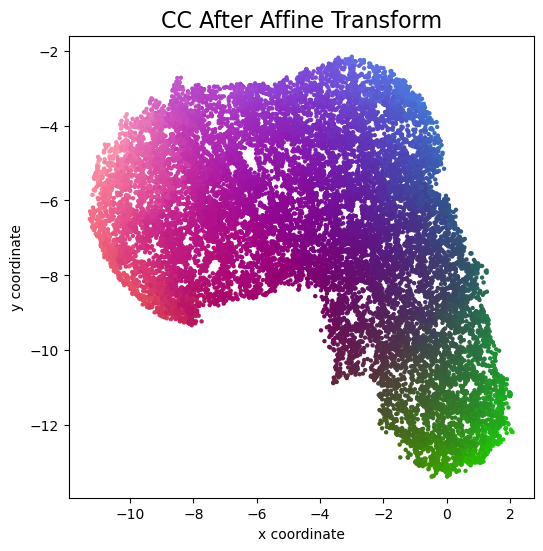

MAE: 0.3308
CEP: 0.2904


In [4]:
for i in range(20):
    p = mp.Process(target=objective_process, args=(result_queue,))
    p.start()
    p.join()

    mae, cep = result_queue.get()
    maes.append(mae)
    ceps.append(cep)

In [5]:
import matplotlib.pyplot as plt

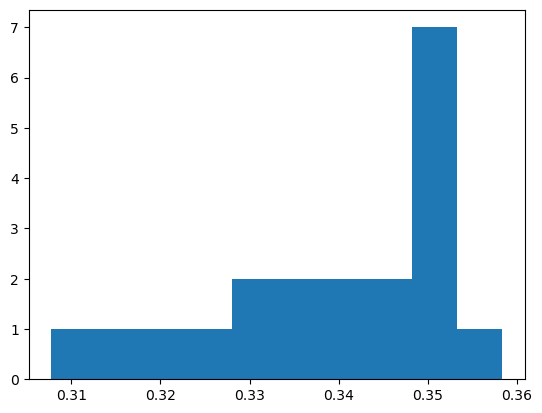

In [6]:
plt.hist(maes)
plt.show()

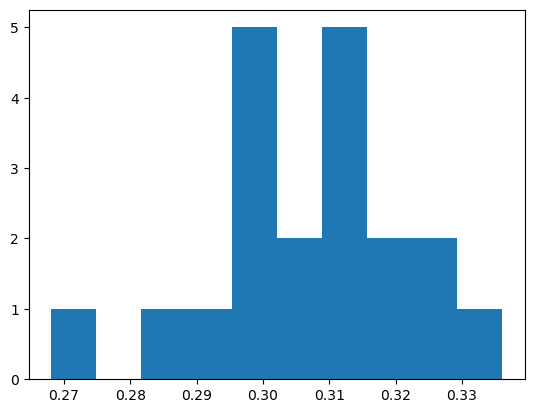

In [7]:
plt.hist(ceps)
plt.show()

In [ ]:
print(f"Mean MAE: {np.mean(maes):.3f}")
print(f"Mean CEP: {np.mean(ceps):.3f}")

Mean MAE: 0.339
Mean CEP: 0.307
